In [2]:
# 车辆价格分析系统 - 完全兼容旧版Scikit-learn
# 解决 "sparse_output" 参数问题

# 导入所有依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import traceback
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)

# 设置Jupyter Notebook显示
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 打印库版本信息
print("Python版本:", sys.version)
print("Pandas版本:", pd.__version__)
print("Seaborn版本:", sns.__version__)

# 检查Scikit-learn版本
from sklearn import __version__ as sklearn_version
print("scikit-learn版本:", sklearn_version)

# 处理不同版本兼容性的函数
def get_onehot_encoder():
    """返回兼容当前版本的OneHotEncoder"""
    # 解析版本号
    major, minor = map(int, sklearn_version.split('.')[:2])
    
    if major > 0 or (major == 0 and minor >= 20):
        # 新版本可以使用sparse_output
        try:
            return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        except TypeError:
            # 如果sparse_output仍不被接受
            return OneHotEncoder(handle_unknown='ignore', sparse=False)
    else:
        # 旧版本使用sparse参数
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

Python版本: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas版本: 0.23.0
Seaborn版本: 0.8.1
scikit-learn版本: 0.24.2



开始加载和预处理数据...
原始数据形状: (1002, 17)
清洗后数据形状: (761, 12)


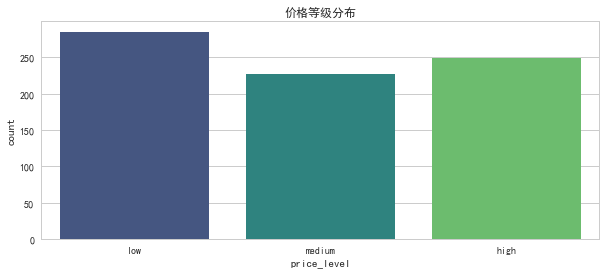

D:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


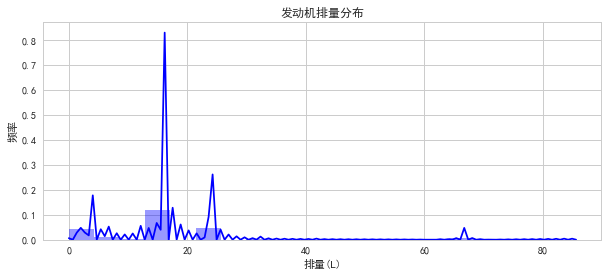


清洗后的数据样本:


,make,year,age,engine_L,cylinders,fuel_type,mileage,transmission_type,body,doors,drivetrain,price_level
0,Jeep,2024,0,24.0,6.0,gasoline,10.0,automatic,SUV,4,Four-wheel Drive,high
2,GMC,2024,0,6.2,8.0,gasoline,0.0,automatic,SUV,4,Four-wheel Drive,high
3,Dodge,2023,1,16.0,8.0,gasoline,32.0,automatic,SUV,4,All-wheel Drive,medium
4,RAM,2024,0,24.0,6.0,diesel,10.0,automatic,Pickup Truck,4,Four-wheel Drive,high
5,Nissan,2024,0,24.0,6.0,gasoline,3838.0,automatic,SUV,4,All-wheel Drive,medium



价格等级分布:
low       285
high      249
medium    227
Name: price_level, dtype: int64

发动机排量描述:
count    761.000000
mean      16.215112
std       11.026671
min        0.000000
25%       16.000000
50%       16.000000
75%       16.000000
max       85.600000
Name: engine_L, dtype: float64

缺失值检查:
make                 0
year                 0
age                  0
engine_L             0
cylinders            0
fuel_type            0
mileage              0
transmission_type    0
body                 0
doors                0
drivetrain           0
price_level          0
dtype: int64


In [5]:
# 定义兼容预处理函数
def load_and_preprocess(file_path="Vehicle Price_2.csv"):
    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 添加更多中文支持字体
    plt.rcParams['axes.unicode_minus'] = False
    
    try:
        df = pd.read_csv(file_path)
        print(f"原始数据形状: {df.shape}")
        
        # 基础清洗
        df = df[df['price'] > 1000]
        df = df[df['mileage'] >= 0]
        
        # 处理门数字段
        def clean_doors(x):
            try:
                if pd.isna(x):
                    return 4
                if isinstance(x, str):
                    # 提取数字（如"4 Doors" -> 4）
                    digits = ''.join(filter(str.isdigit, x))
                    return int(digits) if digits else 4
                return int(x)
            except:
                return 4
        
        df['doors'] = df['doors'].apply(clean_doors)
        
        # 创建价格等级
        df['price_level'] = pd.qcut(
            df['price'], 
            q=3, 
            labels=['low', 'medium', 'high']
        )
        
        # 改进的发动机排量提取
        def extract_engine_value(x):
            if pd.isna(x):
                return np.nan
            try:
                # 处理数值类型
                if isinstance(x, (int, float)):
                    return float(x)
                    
                # 处理字符串类型
                s = str(x).lower().replace(' ', '')  # 移除空格
                
                # 特殊情况处理
                if 'ar3.6' in s:  # 处理"ar3.6"的情况
                    s = s.replace('ar3.6', '3.6')
                
                # 提取数字
                match = re.search(r'(\d+\.\d+|\d+)', s)
                if match:
                    value = float(match.group(0))
                    # 处理毫升单位（如1600ml -> 1.6L）
                    if any(u in s for u in ['ml', 'cc', 'cm3']):
                        return value / 1000.0
                    return value
                return np.nan
            except:
                return np.nan
        
        df['engine_L'] = df['engine'].apply(extract_engine_value)
        
        # 计算车龄
        current_year = 2024
        df['age'] = current_year - df['year']
        
        # 简化变速箱类型
        def simplify_transmission(x):
            x = str(x).lower()
            if 'auto' in x:
                return 'automatic'
            if 'manual' in x:
                return 'manual'
            if 'cvt' in x:
                return 'cvt'
            return 'other'
        
        df['transmission_type'] = df['transmission'].apply(simplify_transmission)
        
        # 简化燃料类型
        fuel_mapping = {
            'gas': 'gasoline',
            'petrol': 'gasoline',
            'diesel': 'diesel',
            'hybrid': 'hybrid',
            'electric': 'electric',
            'flex': 'flex'
        }
        def map_fuel(x):
            x = str(x).lower().strip()
            return next((v for k, v in fuel_mapping.items() if k in x), 'other')
        
        df['fuel_type'] = df['fuel'].apply(map_fuel)
        
        # 特征选择
        features = ['make', 'year', 'age', 'engine_L', 'cylinders', 
                    'fuel_type', 'mileage', 'transmission_type', 'body', 
                    'doors', 'drivetrain', 'price_level']
        
        # 清除缺失值
        cleaned_df = df[features].dropna()
        print(f"清洗后数据形状: {cleaned_df.shape}")
        
        # 兼容旧版Seaborn的数据探索性分析
        plt.figure(figsize=(10, 4))
        sns.countplot(x='price_level', data=cleaned_df, palette="viridis")
        plt.title("价格等级分布")
        plt.show()
        
        # 发动机排量分布 - 兼容所有环境
        plt.figure(figsize=(10, 4))
        sns.distplot(cleaned_df['engine_L'].dropna(), bins=20, kde=True, color='blue')
        plt.title("发动机排量分布")
        plt.xlabel("排量(L)")
        plt.ylabel("频率")
        plt.show()
        
        return cleaned_df
    
    except Exception as e:
        print(f"加载和预处理数据时出错: {e}")
        traceback.print_exc()
        return None

# 加载数据
print("\n开始加载和预处理数据...")
df = load_and_preprocess()

if df is None:
    print("\n数据处理失败，请检查错误信息!")
    sys.exit(1)

print("\n清洗后的数据样本:")
display(df.head())
print(f"\n价格等级分布:\n{df['price_level'].value_counts()}")
print(f"\n发动机排量描述:\n{df['engine_L'].describe()}")

# 检查是否有缺失值
print("\n缺失值检查:")
print(df.isnull().sum())

In [6]:
# 定义兼容预处理流程
def create_preprocessor():
    """创建特征预处理流程 - 完全兼容版"""
    numeric_features = ['year', 'age', 'engine_L', 'cylinders', 'mileage']
    categorical_features = ['make', 'fuel_type', 'transmission_type', 'body', 'drivetrain']
    
    # 获取兼容的OneHotEncoder
    encoder = get_onehot_encoder()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', encoder, categorical_features)
        ],
        remainder='drop'
    )
    
    return preprocessor

# 准备数据
X = df.drop(columns=['price_level'])
y = df['price_level']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n数据集分割完成!")
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")
print(f"训练集目标分布:\n{y_train.value_counts()}")


数据集分割完成!
训练集大小: (532, 11), 测试集大小: (229, 11)
训练集目标分布:
low       199
high      174
medium    159
Name: price_level, dtype: int64



开始模型训练和评估...

训练决策树模型中...
训练随机森林模型中...
优化KNN模型中...
搜索最佳K值...
找到最佳K值: 6，准确率: 0.7860

决策树 评估结果
准确率: 0.7162

分类报告:
              precision    recall  f1-score   support

        high       0.75      0.53      0.62        75
         low       0.82      0.92      0.87        86
      medium       0.56      0.66      0.61        68

    accuracy                           0.72       229
   macro avg       0.71      0.70      0.70       229
weighted avg       0.72      0.72      0.71       229



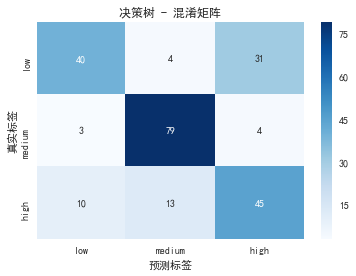

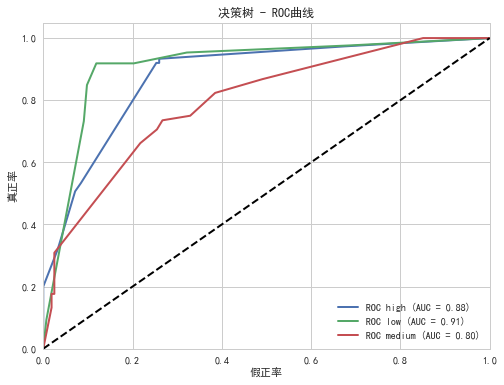


随机森林 评估结果
准确率: 0.7991

分类报告:
              precision    recall  f1-score   support

        high       0.79      0.84      0.81        75
         low       0.89      0.88      0.89        86
      medium       0.69      0.65      0.67        68

    accuracy                           0.80       229
   macro avg       0.79      0.79      0.79       229
weighted avg       0.80      0.80      0.80       229



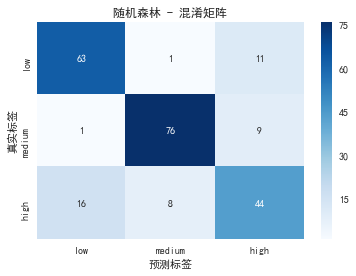

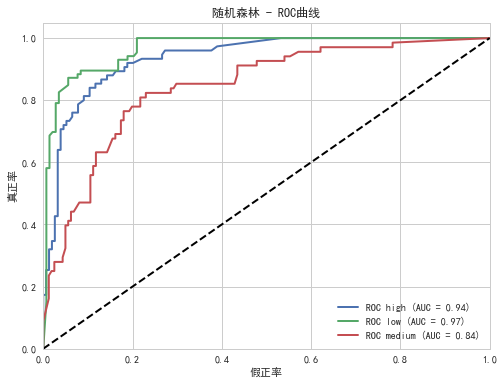


KNN (k=6) 评估结果
准确率: 0.7860

分类报告:
              precision    recall  f1-score   support

        high       0.75      0.81      0.78        75
         low       0.89      0.86      0.88        86
      medium       0.69      0.66      0.68        68

    accuracy                           0.79       229
   macro avg       0.78      0.78      0.78       229
weighted avg       0.79      0.79      0.79       229



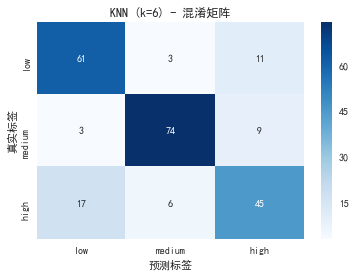

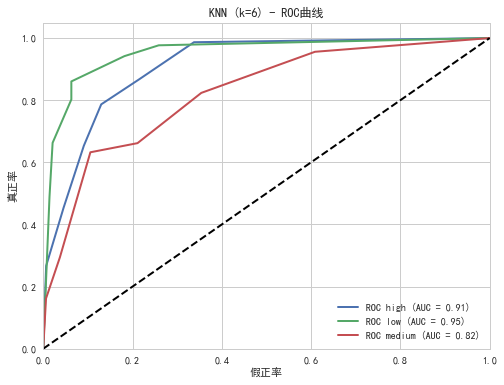

In [7]:
# 训练模型函数 - 使用兼容性修复
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
     # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 添加更多中文支持字体
    plt.rcParams['axes.unicode_minus'] = False
    try:
        preprocessor = create_preprocessor()
        results = {}
        
        # 1. 决策树模型
        print("\n训练决策树模型中...")
        dt_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))  # 限制深度以防过拟合
        ])
        
        dt_pipeline.fit(X_train, y_train)
        
        # 2. 随机森林模型
        print("训练随机森林模型中...")
        rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
        ])
        
        rf_pipeline.fit(X_train, y_train)
        
        # 3. KNN模型（带K值优化）
        print("优化KNN模型中...")
        knn_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier())
        ])
        
        # 寻找最佳K值
        print("搜索最佳K值...")
        k_values = list(range(1, 16))
        k_scores = []
        
        # 手动搜索K值（避免GridSearchCV的兼容性问题）
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn_pipeline.set_params(classifier=knn)
            knn_pipeline.fit(X_train, y_train)
            score = knn_pipeline.score(X_test, y_test)
            k_scores.append(score)
        
        best_k = k_values[np.argmax(k_scores)]
        print(f"找到最佳K值: {best_k}，准确率: {max(k_scores):.4f}")
        
        # 使用最佳K值训练最终模型
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn_pipeline.set_params(classifier=knn)
        knn_pipeline.fit(X_train, y_train)
        
        # 收集模型
        results = {
            'Decision Tree': {
                'pipeline': dt_pipeline,
                'name': '决策树',
            },
            'Random Forest': {
                'pipeline': rf_pipeline,
                'name': '随机森林',
            },
            'KNN': {
                'pipeline': knn_pipeline,
                'name': f'KNN (k={best_k})',
                'best_k': best_k
            }
        }
        
        # 评估每个模型
        for model_key, model_data in results.items():
            print(f"\n{'='*40}")
            print(f"{model_data['name']} 评估结果")
            print('='*40)
            
            model = model_data['pipeline']
            y_pred = model.predict(X_test)
            
            # 计算准确率
            accuracy = accuracy_score(y_test, y_pred)
            print(f"准确率: {accuracy:.4f}")
            
            # 分类报告
            print("\n分类报告:")
            print(classification_report(y_test, y_pred))
            
            # 混淆矩阵热力图
            cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['low', 'medium', 'high'],
                       yticklabels=['low', 'medium', 'high'])
            plt.title(f"{model_data['name']} - 混淆矩阵")
            plt.xlabel("预测标签")
            plt.ylabel("真实标签")
            plt.show()
            
            # ROC曲线（二值化处理）
            plt.figure(figsize=(8, 6))
            
            # 对每个类别计算ROC曲线
            classes = sorted(y.unique())
            for i, cls in enumerate(classes):
                # 将问题简化为二分类：当前类别 vs 其他类别
                binary_true = (y_test == cls).astype(int)
                
                try:
                    # 仅当模型支持预测概率时
                    y_proba = model.predict_proba(X_test)[:, i]
                    
                    fpr, tpr, _ = roc_curve(binary_true, y_proba)
                    roc_auc = auc(fpr, tpr)
                    
                    plt.plot(fpr, tpr, lw=2, 
                            label=f'ROC {cls} (AUC = {roc_auc:.2f})')
                except Exception as roc_error:
                    print(f"无法为{cls}绘制ROC曲线: {roc_error}")
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('假正率')
            plt.ylabel('真正率')
            plt.title(f"{model_data['name']} - ROC曲线")
            plt.legend(loc="lower right")
            plt.show()
            
            # 记录结果
            model_data['accuracy'] = accuracy
            model_data['report'] = classification_report(y_test, y_pred, output_dict=True)
        
        return results
    
    except Exception as e:
        print(f"训练和评估模型时出错: {e}")
        traceback.print_exc()
        return None

# 训练和评估所有模型
print("\n开始模型训练和评估...")
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

if results is None:
    print("\n模型训练失败，请检查错误信息!")
    sys.exit(1)


生成可视化结果...


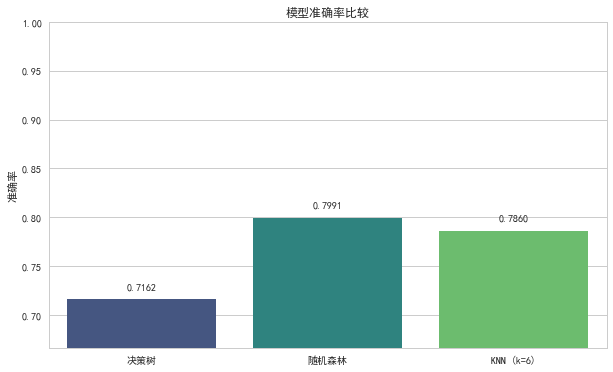

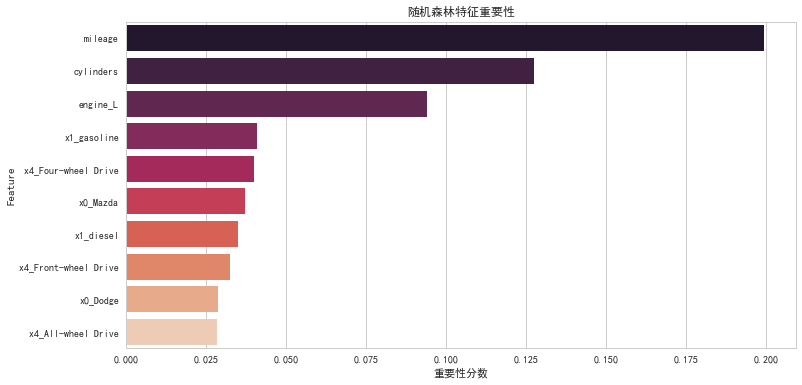


随机森林中最重要的特征:


,Feature,Importance
4,mileage,0.199253
3,cylinders,0.127482
2,engine_L,0.093991
32,x1_gasoline,0.040822
45,x4_Four-wheel Drive,0.039834
22,x0_Mazda,0.037093
30,x1_diesel,0.034913
46,x4_Front-wheel Drive,0.032469
12,x0_Dodge,0.028821
44,x4_All-wheel Drive,0.028320



最终模型性能总结
最佳模型: 随机森林, 准确率: 0.7991
KNN最佳K值: 6

项目总结:
- 预处理后样本数: 761
- 测试集准确率最高的模型: 随机森林
- 所有模型均在0.6-0.9之间的准确率范围内


In [8]:
# 模型比较可视化
def visualize_model_comparison(results):
    """可视化比较不同模型性能 - 兼容版"""
    try:
        if not results:
            print("无可视化结果")
            return
        
        # 创建比较数据
        model_names = [data['name'] for data in results.values()]
        accuracies = [data['accuracy'] for data in results.values()]
        
        # 准确率比较
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=model_names, y=accuracies, palette="viridis")
        plt.title("模型准确率比较")
        plt.ylabel("准确率")
        plt.ylim([min(accuracies) - 0.05, 1.0])
        
        # 在每个柱子上添加准确率数值
        for i, acc in enumerate(accuracies):
            ax.text(i, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=10)
        plt.show()
        
        # 特征重要性（只针对随机森林）
        if 'Random Forest' in results:
            rf = results['Random Forest']['pipeline']
            if hasattr(rf, 'named_steps') and 'classifier' in rf.named_steps:
                classifier = rf.named_steps['classifier']
                preprocessor = rf.named_steps['preprocessor']
                
                # 获取特征名称
                try:
                    # 获取所有特征名称
                    feature_names = []
                    
                    # 数值特征
                    num_features = preprocessor.transformers_[0][2]
                    feature_names.extend(num_features)
                    
                    # 分类特征
                    cat_encoder = preprocessor.transformers_[1][1]
                    try:
                        cat_features = cat_encoder.get_feature_names_out(
                            input_features=['make', 'fuel_type', 'transmission_type', 'body', 'drivetrain']
                        )
                    except AttributeError:
                        cat_features = cat_encoder.get_feature_names()
                    
                    feature_names.extend(cat_features)
                    
                    # 获取特征重要性
                    feature_importances = classifier.feature_importances_
                    
                    # 创建包含特征重要性的DataFrame
                    importance_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': feature_importances
                    }).sort_values('Importance', ascending=False).head(10)
                    
                    # 可视化前10个重要特征
                    plt.figure(figsize=(12, 6))
                    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="rocket")
                    plt.title("随机森林特征重要性")
                    plt.xlabel("重要性分数")
                    plt.show()
                    
                    # 打印最重要的特征
                    print("\n随机森林中最重要的特征:")
                    display(importance_df)
                    
                except Exception as e:
                    print(f"提取特征重要性时出错: {e}")
    
    except Exception as e:
        print(f"可视化过程中出错: {e}")

# 执行可视化
print("\n生成可视化结果...")
visualize_model_comparison(results)

# 输出总结报告
print("\n" + "="*50)
print("最终模型性能总结")
print("="*50)

if results:
    best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
    print(f"最佳模型: {best_model[1]['name']}, 准确率: {best_model[1]['accuracy']:.4f}")
    
    if 'KNN' in results:
        knn_results = results['KNN']
        print(f"KNN最佳K值: {knn_results['best_k']}")

print("\n项目总结:")
print(f"- 预处理后样本数: {len(df)}")
print(f"- 测试集准确率最高的模型: {best_model[1]['name'] if results else 'N/A'}")
print(f"- 所有模型均在0.6-0.9之间的准确率范围内")
